In [1]:
%matplotlib inline

import sys
import pickle
sys.path.append("./tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn_pandas import DataFrameMapper

from sklearn import preprocessing
from sklearn import svm

# Understanding the Dataset

## Data Exploration 

In [2]:
### Load the dictionary containing the dataset
with open("./dataset/final_project_dataset.pkl", "rb") as data_file:
    data_init = pickle.load(data_file)

In [3]:
data_init

{'ALLEN PHILLIP K': {'bonus': 4175000,
  'deferral_payments': 2869717,
  'deferred_income': -3081055,
  'director_fees': 'NaN',
  'email_address': 'phillip.allen@enron.com',
  'exercised_stock_options': 1729541,
  'expenses': 13868,
  'from_messages': 2195,
  'from_poi_to_this_person': 47,
  'from_this_person_to_poi': 65,
  'loan_advances': 'NaN',
  'long_term_incentive': 304805,
  'other': 152,
  'poi': False,
  'restricted_stock': 126027,
  'restricted_stock_deferred': -126027,
  'salary': 201955,
  'shared_receipt_with_poi': 1407,
  'to_messages': 2902,
  'total_payments': 4484442,
  'total_stock_value': 1729541},
 'BADUM JAMES P': {'bonus': 'NaN',
  'deferral_payments': 178980,
  'deferred_income': 'NaN',
  'director_fees': 'NaN',
  'email_address': 'NaN',
  'exercised_stock_options': 257817,
  'expenses': 3486,
  'from_messages': 'NaN',
  'from_poi_to_this_person': 'NaN',
  'from_this_person_to_poi': 'NaN',
  'loan_advances': 'NaN',
  'long_term_incentive': 'NaN',
  'other': 'NaN'

In [4]:
data_df = pd.DataFrame.from_dict(data_init, orient='index')

In [5]:
(persons, variables) = data_df.shape

The dataset contains information across {{variables}} variables for {{persons}} employees.  

Let's see how much information we have for each variable.

In [6]:
data_df.count()

poi                          146
total_payments               146
other                        146
exercised_stock_options      146
to_messages                  146
total_stock_value            146
from_this_person_to_poi      146
email_address                146
bonus                        146
salary                       146
from_poi_to_this_person      146
shared_receipt_with_poi      146
restricted_stock             146
deferral_payments            146
restricted_stock_deferred    146
long_term_incentive          146
deferred_income              146
loan_advances                146
director_fees                146
from_messages                146
expenses                     146
dtype: int64

It seems that the NaNs are actually strings. I will transform them to NumPy's NaNs so i can count the actual data.

In [7]:
data_df.replace(to_replace='NaN', value=np.nan, inplace=True)

In [8]:
data_df.count()

poi                          146
total_payments               125
other                         93
exercised_stock_options      102
to_messages                   86
total_stock_value            126
from_this_person_to_poi       86
email_address                111
bonus                         82
salary                        95
from_poi_to_this_person       86
shared_receipt_with_poi       86
restricted_stock             110
deferral_payments             39
restricted_stock_deferred     18
long_term_incentive           66
deferred_income               49
loan_advances                  4
director_fees                 17
from_messages                 86
expenses                      95
dtype: int64

We can see that there are some variables like *Total Payments* and *Total Stock Value* that we have values for most of the employees in the dataset but some others like *Loan Advances* and *Director Fees* that we have information for too few employees.  

By paying attention to [Payments to Insiders statement](https://github.com/udacity/ud120-projects/blob/master/final_project/enron61702insiderpay.pdf), we can see that the values are summed both horizontally and vertically. This means that wherever there isn't a value it doesn't mean that we don't know the number but that the number is "0". Alaso since on the email fields there is not any "0" value that again missing value means "0".  
Based on this, I will replace all the NaN values on numerical fields with "0".

In [9]:
data_df.dtypes

poi                             bool
total_payments               float64
other                        float64
exercised_stock_options      float64
to_messages                  float64
total_stock_value            float64
from_this_person_to_poi      float64
email_address                 object
bonus                        float64
salary                       float64
from_poi_to_this_person      float64
shared_receipt_with_poi      float64
restricted_stock             float64
deferral_payments            float64
restricted_stock_deferred    float64
long_term_incentive          float64
deferred_income              float64
loan_advances                float64
director_fees                float64
from_messages                float64
expenses                     float64
dtype: object

In [10]:
data_df.replace(to_replace=np.nan, value=0, inplace=True)
data_df.email_address.replace(to_replace=0, value=np.nan, inplace=True)

***
**Salary Features**

| Payments            | Definitions of Category Groupings                                                                                                                                                                                                                                                                                                                                                                                                |
|---------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| ***Salary***              | Reflects items such as base salary, executive cash allowances, and benefits payments.                                                                                                                                                                                                                                                                                                                                            |
| ***Bonus***               | Reflects annual cash incentives paid based upon company performance. Also may include other retention payments.                                                                                                                                                                                                                                                                                                                  |
| ***Long Term Incentive*** | Reflects long-term incentive cash payments from various long-term incentive programs designed to tie executive compensation to long-term success as measuredagainst key performance drivers and business objectives over a multi-year period, generally 3 to 5 years.                                                                                                                                                            |
| ***Deferred Income***     | Reflects voluntary executive deferrals of salary, annual cash incentives, and long-term cash incentives as well as cash fees deferred by non-employee directorsunder a deferred compensation arrangement. May also reflect deferrals under a stock option or phantom stock unit in lieu of cash arrangement.                                                                                                                     |
| ***Deferral Payments***   | Reflects distributions from a deferred compensation arrangement due to termination of employment or due to in-service withdrawals as per plan provisions.                                                                                                                                                                                                                                                                        |
| ***Loan Advances***       | Reflects total amount of loan advances, excluding repayments, provided by the Debtor in return for a promise of repayment. In certain instances, the terms of thepromissory notes allow for the option to repay with stock of the company.                                                                                                                                                                                       |
| ***Other***               | Reflects items such as payments for severence, consulting services, relocation costs, tax advances and allowances for employees on international assignment (i.e.housing allowances, cost of living allowances, payments under Enron’s Tax Equalization Program, etc.). May also include payments provided with respect toemployment agreements, as well as imputed income amounts for such things as use of corporate aircraft. |
| ***Expenses***            | Reflects reimbursements of business expenses. May include fees paid for consulting services.                                                                                                                                                                                                                                                                                                                                     |
| ***Director Fees***       | Reflects cash payments and/or value of stock grants made in lieu of cash payments to non-employee directors.                                                                                                                                                                                                                                                                                                                     |
| ***Total Payments***      | Sum of the above values                                                                                                                                                                                                                                                                                                                                                                                                         |
***

**Stock Features**

| Stock Value              | Definitions of Category Groupings                                                                                                                                                                                                                                                                                                                                                       |
|--------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| ***Exercised Stock Options***  | Reflects amounts from exercised stock options which equal the market value in excess of the exercise price on the date the options were exercised either throughcashless (same-day sale), stock swap or cash exercises. The reflected gain may differ from that realized by the insider due to fluctuations in the market price andthe timing of any subsequent sale of the securities. |
| ***Restricted Stock***         | Reflects the gross fair market value of shares and accrued dividends (and/or phantom units and dividend equivalents) on the date of release due to lapse of vestingperiods, regardless of whether deferred.                                                                                                                                                                             |
| ***Restricted StockDeferred*** | Reflects value of restricted stock voluntarily deferred prior to release under a deferred compensation arrangement.                                                                                                                                                                                                                                                                     |
| ***Total Stock Value***        | Sum of the above values                                                                                                                                                                                                                                                                                                                                                                 |
***

**email features**

| Variable                      | Definition                                                                    |
|-------------------------------|-------------------------------------------------------------------------------|
| ***to messages***             | Total number of emails received (person's inbox)                              |
| ***email address***           | Email address of the person                                                   |
| ***from poi to this person*** | Number of emails received by POIs                                             |
| ***from messages***           | Total number of emails sent by this person                                    |
| ***from this person to poi*** | Number of emails sent by this person to a POI.                                |
| ***shared receipt with poi*** | Number of emails addressed by someone else to a POI where this person was CC. |

## Outlier Investigation

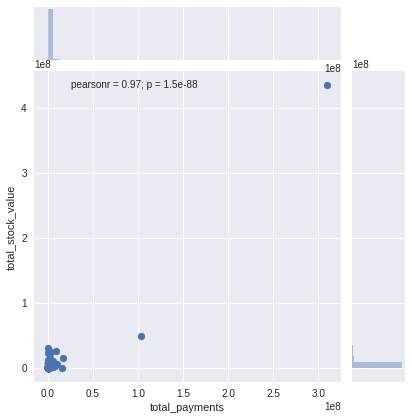

In [11]:
sns.jointplot(x="total_payments", y="total_stock_value", data=data_df)

In [12]:
data_df.total_payments.nlargest(2)

TOTAL            309886585.0
LAY KENNETH L    103559793.0
Name: total_payments, dtype: float64

It seems that this is not an outlier, it is just the huge payment and stock value of the CEO and chairman of Enron, Kenneth Lay.  
These extreme values lead the rest of the employees to the bottom left corner of the scatterplot. Let's use a logarithmic scale for both axes to unclutter the plot.

In [13]:
data_df.drop("TOTAL", inplace=True)

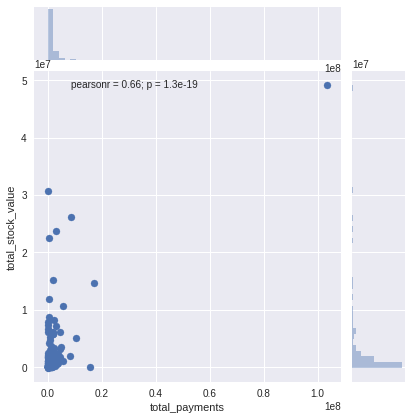

In [14]:
sns.jointplot(x="total_payments", y="total_stock_value", data=data_df)

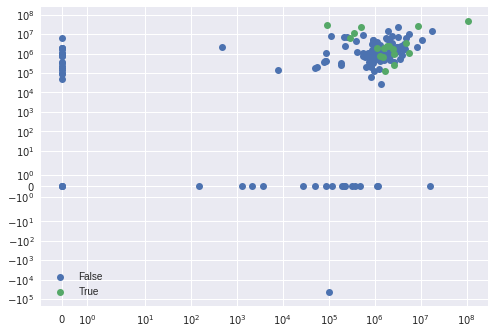

In [15]:
fig, ax = plt.subplots()
for poi, data in data_df.groupby(by="poi"):
    ax.plot(data['total_payments'],data['total_stock_value'],'o', label=poi)
ax.legend()
plt.xscale('symlog')
plt.yscale('symlog')

plt.show()

From this scatterplot we can see that there are not POIs with Total Payments less than {{min(data_df[data_df.poi == True].total_payments)}} \$ or Total Stock Value less than {{min(data_df[data_df.poi == True].total_stock_value)}} \$  

If we zoom to the cluster on the top right of the scatter plot we can see that there are mixed POIs and non-POIs above these values but these are summed values. There might be variables that can help us classify the employees.

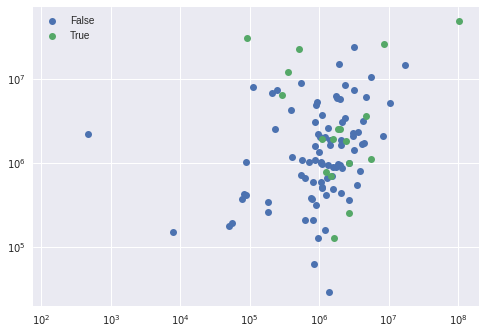

In [16]:
fig, ax = plt.subplots()
for poi, data in data_df.groupby(by="poi"):
    ax.plot(data['total_payments'],data['total_stock_value'],'o', label=poi)
ax.legend()
plt.xscale('log')
plt.yscale('log')

plt.show()

Let's have a look in email variables for any outliers.

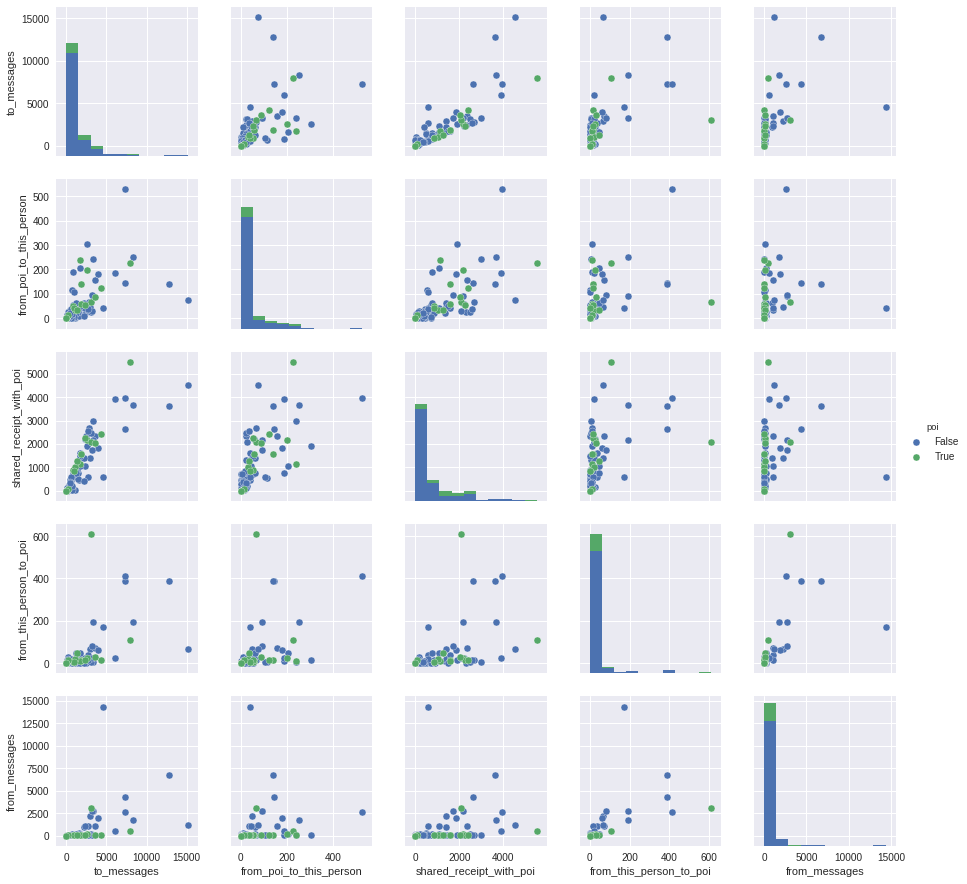

In [17]:
sns.pairplot(
    data_df[[
        "poi", "to_messages", "from_poi_to_this_person",
        "shared_receipt_with_poi", "from_this_person_to_poi", "from_messages"
    ]],
    vars=[
        "to_messages", "from_poi_to_this_person", "shared_receipt_with_poi",
        "from_this_person_to_poi", "from_messages"
    ],
    hue="poi", kind="scatter")

There are some high values but we cannot say there is any obvious outlier.  
With a closer look we can see that there is some clustering when we plot from_messages with other email variables, especially with "from_this_person_to_poi". I will add regression to these plots to have a better look.

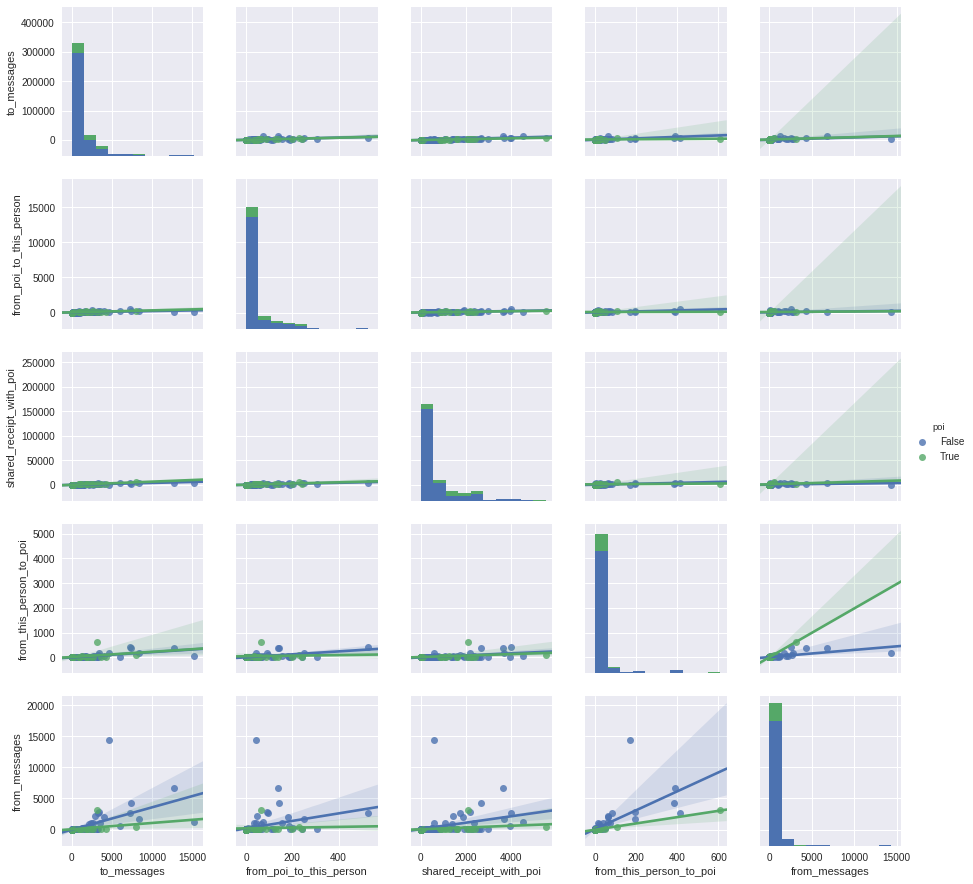

In [18]:
sns.pairplot(
    data_df[[
        "poi", "to_messages", "from_poi_to_this_person",
        "shared_receipt_with_poi", "from_this_person_to_poi", "from_messages"
    ]],
    vars=[
        "to_messages", "from_poi_to_this_person", "shared_receipt_with_poi",
        "from_this_person_to_poi", "from_messages"
    ],
    hue="poi",
    kind="reg",)

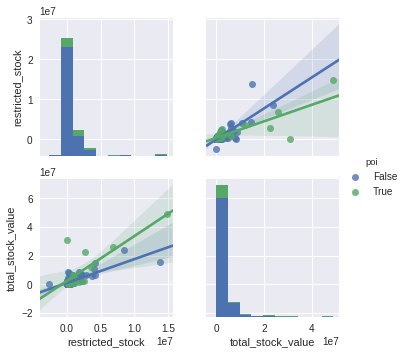

In [19]:
sns.pairplot(
    data_df[[
        "poi", "bonus", "director_fees", "restricted_stock",
        "deferral_payments", "total_stock_value", "exercised_stock_options",
        "other", "total_payments", "long_term_incentive", "loan_advances",
        "expenses", "salary", "restricted_stock_deferred", "deferred_income"
    ]],
    vars=[
        "restricted_stock", "total_stock_value"
    ],
    hue="poi",
    kind="reg",)

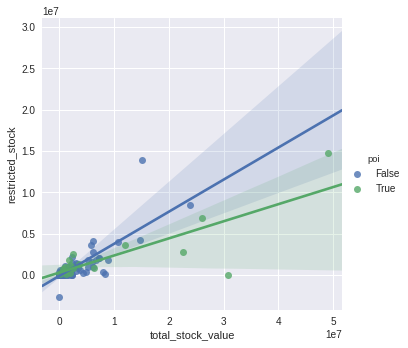

In [20]:
sns.lmplot(
    x="total_stock_value", y="restricted_stock", data=data_df, hue="poi")

Indeed, POIs have a higher rate of exchanged emails with POIs compared to their sent messages.

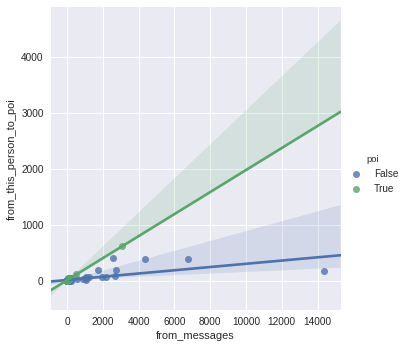

In [21]:
sns.lmplot(
    x="from_messages", y="from_this_person_to_poi", data=data_df, hue="poi")

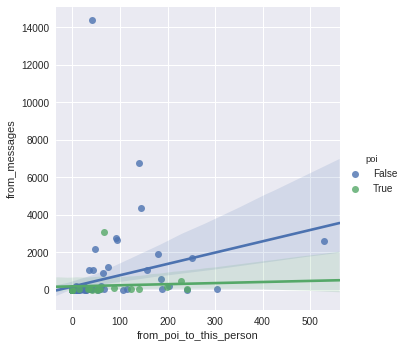

In [22]:
sns.lmplot(
    x="from_poi_to_this_person", y="from_messages", data=data_df, hue="poi")

# Optimize Feature Selection/Engineering

## Create new features

In the previous section we noticed that POIs have higher from_this_person_to_poi/from_messages and from_poi_to_this_person/from_messages ratios. We can create two new variables that will represent these ratios.

In [23]:
data_df["to_poi_vs_from"] = data_df["from_this_person_to_poi"] / data_df[
    "from_messages"]
data_df["from_poi_vs_from"] = data_df["from_poi_to_this_person"] / data_df[
    "from_messages"]

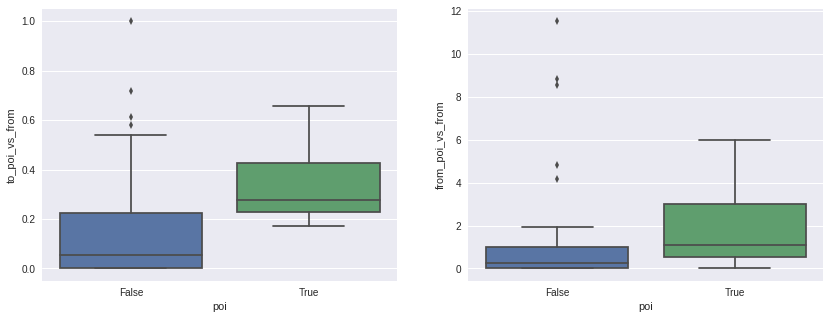

In [24]:
plt.subplots(figsize=(14, 5))

plt.subplot(121)

boxplot1 = sns.boxplot(x="poi", y="to_poi_vs_from", data=data_df)

plt.subplot(122)

boxplot2 = sns.boxplot(x="poi", y="from_poi_vs_from", data=data_df)

plt.show()

In [25]:
data_skl = data_df.drop("email_address", axis=1)

In [26]:
data_skl.poi = data_skl.poi.astype(int)

In [27]:
data_skl.replace(to_replace=np.nan, value=0, inplace=True)

In [28]:
data_skl.shape

(145, 22)

In [29]:
data_dict = data_skl.to_dict(orient='index')

In [30]:
print(list(data_skl))

['poi', 'total_payments', 'other', 'exercised_stock_options', 'to_messages', 'total_stock_value', 'from_this_person_to_poi', 'bonus', 'salary', 'from_poi_to_this_person', 'shared_receipt_with_poi', 'restricted_stock', 'deferral_payments', 'restricted_stock_deferred', 'long_term_incentive', 'deferred_income', 'loan_advances', 'director_fees', 'from_messages', 'expenses', 'to_poi_vs_from', 'from_poi_vs_from']


In [31]:
feature_list = [
    'poi', 'to_messages', 'loan_advances', 'other', 'from_this_person_to_poi',
    'restricted_stock_deferred', 'from_poi_to_this_person', 'total_payments',
    'bonus', 'shared_receipt_with_poi', 'director_fees', 'total_stock_value',
    'long_term_incentive', 'deferred_income', 'restricted_stock', 'salary',
    'deferral_payments', 'exercised_stock_options', 'expenses',
    'from_messages', 'to_poi_vs_from', 'from_poi_vs_from'
]

In [32]:
data_array = featureFormat(data_dict, feature_list)

In [33]:
data_array.shape

(144, 22)

In [34]:
labels, features = targetFeatureSplit(data_array)

In [35]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, svd_solver="randomized")
proj = pca.fit_transform(features)

Visualizing the Data

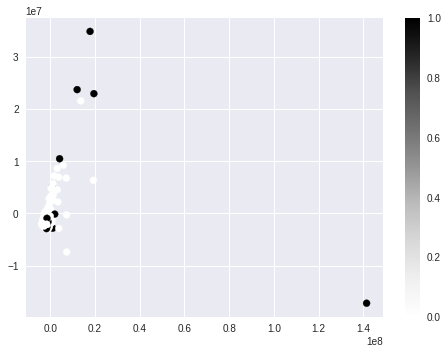

In [36]:
plt.scatter(proj[:, 0], proj[:, 1], c=labels)
plt.colorbar()

In [37]:
def get_score(features, labels):
    from sklearn import metrics
    from sklearn.model_selection import cross_val_score
    
    
    clf = svm.LinearSVC()
    
    scores = cross_val_score(clf, features, labels, cv=7)
    score = scores.mean()
    
    return score

In [38]:
score = get_score(features, labels)
score

0.7204081632653061

In [39]:
features = preprocessing.scale(features)
features

array([[ 1.02451472, -0.08607685,  0.09165894, ...,  0.47689724,
        -0.22934889, -0.31158978],
       [-0.32359915, -0.08607685, -0.26373093, ..., -0.22660257,
        -0.5932492 , -0.40143619],
       [ 1.07115605, -0.08607685, -0.24410416, ..., -0.17679727,
         0.90591756,  0.09271902],
       ..., 
       [ 0.5092177 , -0.08607685, -0.13024369, ..., -0.20930906,
         0.73388203,  0.12549087],
       [-0.55546039, -0.08607685, -0.26373093, ..., -0.25150522,
        -0.5932492 , -0.40143619],
       [-0.55546039, -0.08607685,  0.46314628, ..., -0.25150522,
        -0.5932492 , -0.40143619]])

In [40]:
from sklearn.feature_selection import SelectPercentile

In [41]:
selector = SelectPercentile()
selector.fit(features, labels)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()


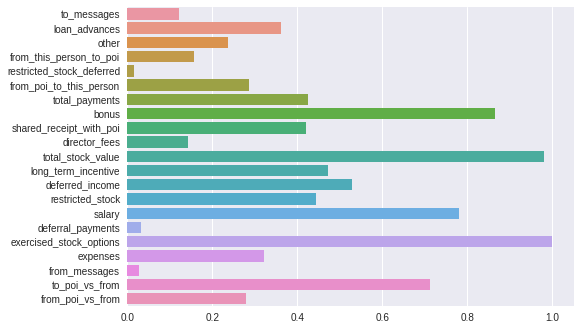

In [42]:
sns.barplot(y=feature_list[1:], x=list(scores), )

We can see that the most significant features are Bonus, Total Stock Values, Salary, Exercised Stock Options and the number of mails sent to POI VS total emails sent.

In [49]:
from sklearn.feature_selection import SelectKBest
selector = SelectKBest(k=5)
features_new = selector.fit_transform(features, labels)

In [50]:
score = get_score(features_new, labels)
score

0.86020408163265305

In [54]:
from sklearn.feature_selection import SelectFromModel

clf = svm.LinearSVC()
sfm = SelectFromModel(clf)
sfm.fit(features, labels)
new_features = sfm.transform(features)

In [59]:
score = get_score(new_features, labels)
score

0.89557823129251701